In [1]:
import os
import re
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
import ast
import json
from glob import glob
import cv2
import time

In [2]:
path_P_DESTRE = '/home/mvlab/Downloads/dataset/P-DESTRE/videos/'
path_pedestrian = '/home/mvlab/Downloads/dataset/통영/'
class_names = ['bg', '"water"', '"waterf"', '"land"', '"animal"']
names = ['fn','cname','id', 'x0', 'y0', 'w', 'h']
max_data_m = 10#000
num_classes = 80
edgecolors = np.random.rand(num_classes, 3) 
edgecolors = np.minimum(edgecolors+0.1, 1.0)

os.path.isdir(path_pedestrian), os.path.isdir(path_P_DESTRE)

(True, True)

In [3]:
path_PDDESTRI = glob(path_P_DESTRE+'*.*')
paths_avi = glob(path_pedestrian+'*.avi')
paths_txt = glob(path_pedestrian+'*.txt')
paths_img = glob(path_pedestrian+'*/*')
len(paths_avi), len(paths_txt), len(paths_img), len(path_PDDESTRI)

(1, 1, 9235, 75)

In [4]:
paths_img[0], paths_img[-1]

('/home/mvlab/Downloads/dataset/통영/bridge_img_01/172056_raw.jpg',
 '/home/mvlab/Downloads/dataset/통영/미수_스마트시티_통영대교_도천방향1(Ch 01)_[20201215]162700-[20201215]163530(20201215_16270_/04337.jpg')

### video label load

In [5]:
df = pd.read_csv(paths_txt[0], header=None, names=names)
df.shape

(1327, 7)

In [6]:
df

,fn,cname,id,x0,y0,w,h
0,2322,person,0,708,832,114,244
1,2323,person,0,710,824,114,244
2,2324,person,0,708,818,114,244
3,2325,person,0,709,817,114,244
4,2326,person,0,708,812,114,244
...,...,...,...,...,...,...,...
1322,3644,person,0,748,276,18,38
1323,3645,person,0,749,277,18,38
1324,3646,person,0,749,277,18,38
1325,3647,person,0,748,276,19,40


In [7]:
df.isna().sum().sum()

0

In [8]:
def set_frame_path(df, paths_img):
    frame = df['fn'].values
    
    file_name_dict = dict()
    
    for path_img in paths_img:
        file_name = path_img.split(os.sep)[-1]
        file_name = file_name.split('.')[0]
        try:
            file_name = int(file_name)
            file_name_dict[file_name] = path_img
        except:
            pass
            
    print('file_name_dict', len(file_name_dict)) 
    
    list_path = []
            
    for fr in frame:
        if fr in file_name_dict.keys():
            list_path.append(file_name_dict[fr])
        else:
            list_path.append(None)
            
    df['path'] = list_path    

set_frame_path(df, paths_img)

file_name_dict 8494


### image label load

In [9]:
path_cut = path_pedestrian + 'bridge_img_01/'
path_cut_label = glob(path_cut + '*.txt')
path_cut, os.path.isdir(path_cut), len(path_cut_label)

('/home/mvlab/Downloads/dataset/통영/bridge_img_01/', True, 1)

In [10]:
path_cut_csv = path_cut_label[0]
path_cut_csv

'/home/mvlab/Downloads/dataset/통영/bridge_img_01/image_label.txt'

In [11]:
names = ['path','cname','id', 'x0', 'y0', 'w', 'h']
df_cut = pd.read_csv(path_cut_csv, names=names)
df_cut['path'] = path_cut + df_cut['path']
df_cut.shape

(409, 7)

In [12]:
df_cut

,path,cname,id,x0,y0,w,h
0,/home/mvlab/Downloads/dataset/통영/bridge_img_01...,person,-1,1064,549,22,56
1,/home/mvlab/Downloads/dataset/통영/bridge_img_01...,person,-1,1087,550,26,61
2,/home/mvlab/Downloads/dataset/통영/bridge_img_01...,person,-1,1061,573,22,54
3,/home/mvlab/Downloads/dataset/통영/bridge_img_01...,person,-1,1081,450,22,26
4,/home/mvlab/Downloads/dataset/통영/bridge_img_01...,person,-1,1080,463,20,50
...,...,...,...,...,...,...,...
404,/home/mvlab/Downloads/dataset/통영/bridge_img_01...,person,-1,1075,678,45,114
405,/home/mvlab/Downloads/dataset/통영/bridge_img_01...,person,-1,1071,690,51,130
406,/home/mvlab/Downloads/dataset/통영/bridge_img_01...,person,-1,1078,716,61,135
407,/home/mvlab/Downloads/dataset/통영/bridge_img_01...,person,-1,1076,742,64,142


In [13]:
df = pd.concat((df, df_cut), axis=0)

In [14]:
annotation = dict()
for i in range(len(df)):
    row = df.iloc[i].values
    fn, cname, iden, x0, y0, w, h, path = row
    x1 = x0 + w
    y1 = y0 + h
    if i%100==0:
        print(i, fn, cname, iden, x0, y0, x1, y1)
    fn = str(fn)
    cls = 3 # land 
    bbox = [cls, x0, y0, x1, y1]
    
    path_image = path
    if path_image in annotation.keys():
        annotation[path_image].extend(bbox)
    else:
        annotation[path_image] = bbox        

0 2322.0 person 0 708 832 822 1076
100 2422.0 person 0 695 635 776 808
200 2522.0 person 0 733 524 800 667
300 2622.0 person 0 747 447 805 570
400 2722.0 person 0 740 409 787 510
500 2822.0 person 0 746 377 787 465
600 2922.0 person 0 739 353 773 425
700 3022.0 person 0 738 331 769 396
800 3122.0 person 0 741 315 769 374
900 3222.0 person 0 735 301 761 357
1000 3322.0 person 0 751 294 774 343
1100 3422.0 person 0 741 282 764 331
1200 3522.0 person 0 744 277 764 319
1300 3622.0 person 0 748 270 767 310
1400 nan person -1 701 561 729 627
1500 nan person -1 1066 539 1091 603
1600 nan person -1 1034 875 1122 1066
1700 nan person -1 1083 410 1103 446


In [15]:
len(annotation)

1530

In [16]:
input_list = []
bbox_list = []
path_list = []
for path_image in annotation:
    cls_bbox = annotation[path_image]
    cls_bbox = np.array(cls_bbox).reshape([-1, 5])
    cls = cls_bbox[:, 0:1]
    bbox = np.array(cls_bbox[:, 1:])
   
    if os.path.isfile(path_image):
        img = Image.open(path_image)    
        scale = np.array((img.width, img.height, img.width, img.height))
        scale = np.reshape(scale, (1, 4))
       
        #print(key, cls, cls_bbox.dtype, cls_bbox, 'wh',img.width, img.height)
        img_arr = np.array(img)        
        bbox_norm = bbox.astype(np.float) / scale.astype(np.float)
        cls_bbox_norm = np.concatenate((cls, bbox_norm), axis=1)

        input_list.append(img_arr)
        bbox_list.append(cls_bbox_norm)
        path_list.append(path_image)
        if len(input_list)%100==0:        
            print(len(annotation), len(input_list), len(bbox_list))   
        if len(input_list) > max_data_m:
            break
    else:
        print('not exist', path_image)

print(len(input_list), len(bbox_list))

11 11


In [17]:
img_w = 1920
bbox = np.concatenate(bbox_list, 0)
bbox_w = (bbox[:, 3] - bbox[:, 1]) * img_w
bbox.shape, np.min(bbox_w), np.max(bbox_w), np.mean(bbox_w)

((11, 5), 108.99999999999999, 114.00000000000003, 112.63636363636357)

(array([3., 0., 0., 0., 0., 0., 0., 0., 0., 8.]),
 array([109. , 109.5, 110. , 110.5, 111. , 111.5, 112. , 112.5, 113. ,
        113.5, 114. ]),
 <a list of 10 Patch objects>)

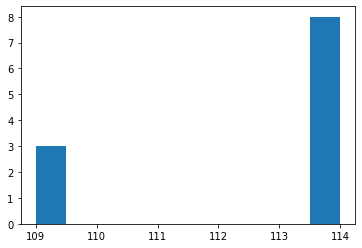

In [18]:
plt.hist(bbox_w)

In [19]:
def visualize_detections_simple(
    image, boxes, classes, figsize=(12, 12), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)    
    
    img_h, img_w, img_c = image.shape
    
    #image = attach_crop_image(image, boxes, max_crop=100)
    
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    boxes_width = boxes[:, 2] - boxes[:, 0]
    boxes_height = boxes[:, 3] - boxes[:, 1]
    box_min_width = np.min(boxes_width)
    box_max_width = np.max(boxes_width)
    title = str.format('(%dx%d) %d box, width:%d ~ %d' 
                       %(img_h, img_w, len(boxes), box_min_width, box_max_width))
    plt.title(title)
    for box, cls in zip(boxes, classes):
        x1, y1, x2, y2 = box        
        w, h = x2 - x1, y2 - y1
        color = edgecolors[int(cls)]
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        if len(boxes) < 70:
            score_txt = class_names[int(cls)]
            ax.text(x1, y1, score_txt, bbox={"facecolor": [1,1,0], "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
        
    plt.show()
    return ax

def display_data(X, BBOX, stride=1):
    for i in range(len(X)):
        if i%stride==0:
            img_arr = X[i]
            sample_box = BBOX[i]
            label = sample_box[:, 0]
            bbox = sample_box[:, 1:]

            h, w, c = img_arr.shape
            scale = np.array((w, h, w, h))
            scale = np.reshape(scale, (1, 4))
            bbox_norm = bbox.astype(np.float) * scale.astype(np.float)
            #print('bbox_norm', bbox, bbox_norm)
            print(i, np.unique(label))
            ax = visualize_detections_simple(img_arr,bbox_norm,label)

0 [3.]


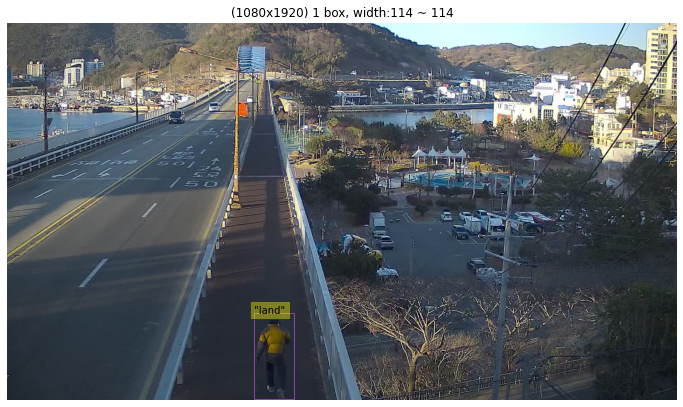

In [20]:
display_data(input_list, bbox_list, stride=200)

In [27]:
def video_to_frames(input_loc, output_loc, stride=1, is_save=True):  
        
    video_file_name = input_loc[:-4]
    output_loc = video_file_name
    print('output_loc', output_loc)
    #return
    if not os.path.isdir(output_loc):
        try:
            os.mkdir(output_loc)
        except OSError:
            pass    
    
    # Log the time
    time_start = time.time()
    # Start capturing the feed
    cap = cv2.VideoCapture(input_loc)
    # Find the number of frames
    
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    print('video_file_name', video_file_name)
    print ("Number of frames: ", video_length)
    count = 0
    print ("Converting video.."+video_file_name+" \n")
    
    while cap.isOpened():
        # Extract the frame
        ret, frame = cap.read()
        
        if (count+np.random.randint(10)) % stride == 0:
            # Write the results back to output location.
            if is_save:
                file_name = output_loc +"/%#05d.jpg"  % (count)
                cv2.imwrite(file_name, frame)
                if False:
                    b, g, r = np.split(frame, 3, -1)
                    rgb = np.concatenate((r,g,b), -1)        
                    img = Image.fromarray(rgb)
                    img.save(file_name)
            else:
                plt.imshow(frame[:,:,::-1])
                plt.show()
            
            # If there are no more frames left
        if count%100==0:
            print('count', video_length, count)
        if (count > (video_length-1)):
            # Log the time again
            time_end = time.time()
            # Release the feed
            cap.release()
            # Print stats
            print ("Done extracting frames.\n%d frames extracted" % count)
            print ("It took %d seconds forconversion." % (time_end-time_start))
            break
        count += 1

In [28]:
for i in range(len(path_PDDESTRI)):
    paths = path_PDDESTRI[i]
    video_to_frames(paths, paths, 30*3, is_save=True)

output_loc /home/mvlab/Downloads/dataset/P-DESTRE/videos/14-11-2019-2-2
video_file_name /home/mvlab/Downloads/dataset/P-DESTRE/videos/14-11-2019-2-2
Number of frames:  1824
Converting video../home/mvlab/Downloads/dataset/P-DESTRE/videos/14-11-2019-2-2 

count 1824 0
count 1824 100
count 1824 200
count 1824 300
count 1824 400
count 1824 500
count 1824 600
count 1824 700
count 1824 800
count 1824 900
count 1824 1000
count 1824 1100
count 1824 1200
count 1824 1300
count 1824 1400
count 1824 1500
count 1824 1600
count 1824 1700
count 1824 1800
Done extracting frames.
1824 frames extracted
It took 25 seconds forconversion.
output_loc /home/mvlab/Downloads/dataset/P-DESTRE/videos/14-07-2019-1-1
video_file_name /home/mvlab/Downloads/dataset/P-DESTRE/videos/14-07-2019-1-1
Number of frames:  774
Converting video../home/mvlab/Downloads/dataset/P-DESTRE/videos/14-07-2019-1-1 

count 774 0
count 774 100
count 774 200
count 774 300
count 774 400
count 774 500
count 774 600
count 774 700
Done extrac

count 1838 0
count 1838 100
count 1838 200
count 1838 300
count 1838 400
count 1838 500
count 1838 600
count 1838 700
count 1838 800
count 1838 900
count 1838 1000
count 1838 1100
count 1838 1200
count 1838 1300
count 1838 1400
count 1838 1500
count 1838 1600
count 1838 1700
count 1838 1800
Done extracting frames.
1838 frames extracted
It took 24 seconds forconversion.
output_loc /home/mvlab/Downloads/dataset/P-DESTRE/videos/13-11-2019-4-2
video_file_name /home/mvlab/Downloads/dataset/P-DESTRE/videos/13-11-2019-4-2
Number of frames:  1037
Converting video../home/mvlab/Downloads/dataset/P-DESTRE/videos/13-11-2019-4-2 

count 1037 0
count 1037 100
count 1037 200
count 1037 300
count 1037 400
count 1037 500
count 1037 600
count 1037 700
count 1037 800
count 1037 900
count 1037 1000
Done extracting frames.
1037 frames extracted
It took 14 seconds forconversion.
output_loc /home/mvlab/Downloads/dataset/P-DESTRE/videos/10-07-2019-1-4
video_file_name /home/mvlab/Downloads/dataset/P-DESTRE/vid

count 2004 1300
count 2004 1400
count 2004 1500
count 2004 1600
count 2004 1700
count 2004 1800
count 2004 1900
count 2004 2000
Done extracting frames.
2004 frames extracted
It took 27 seconds forconversion.
output_loc /home/mvlab/Downloads/dataset/P-DESTRE/videos/13-11-2019-3-4
video_file_name /home/mvlab/Downloads/dataset/P-DESTRE/videos/13-11-2019-3-4
Number of frames:  1829
Converting video../home/mvlab/Downloads/dataset/P-DESTRE/videos/13-11-2019-3-4 

count 1829 0
count 1829 100
count 1829 200
count 1829 300
count 1829 400
count 1829 500
count 1829 600
count 1829 700
count 1829 800
count 1829 900
count 1829 1000
count 1829 1100
count 1829 1200
count 1829 1300
count 1829 1400
count 1829 1500
count 1829 1600
count 1829 1700
count 1829 1800
Done extracting frames.
1829 frames extracted
It took 25 seconds forconversion.
output_loc /home/mvlab/Downloads/dataset/P-DESTRE/videos/13-11-2019-4-4
video_file_name /home/mvlab/Downloads/dataset/P-DESTRE/videos/13-11-2019-4-4
Number of frames:

count 2209 500
count 2209 600
count 2209 700
count 2209 800
count 2209 900
count 2209 1000
count 2209 1100
count 2209 1200
count 2209 1300
count 2209 1400
count 2209 1500
count 2209 1600
count 2209 1700
count 2209 1800
count 2209 1900
count 2209 2000
count 2209 2100
count 2209 2200
Done extracting frames.
2209 frames extracted
It took 29 seconds forconversion.
output_loc /home/mvlab/Downloads/dataset/P-DESTRE/videos/23-10-2019-1-1
video_file_name /home/mvlab/Downloads/dataset/P-DESTRE/videos/23-10-2019-1-1
Number of frames:  1219
Converting video../home/mvlab/Downloads/dataset/P-DESTRE/videos/23-10-2019-1-1 

count 1219 0
count 1219 100
count 1219 200
count 1219 300
count 1219 400
count 1219 500
count 1219 600
count 1219 700
count 1219 800
count 1219 900
count 1219 1000
count 1219 1100
count 1219 1200
Done extracting frames.
1219 frames extracted
It took 16 seconds forconversion.
output_loc /home/mvlab/Downloads/dataset/P-DESTRE/videos/08-11-2019-1-1
video_file_name /home/mvlab/Downloa

Done extracting frames.
1046 frames extracted
It took 14 seconds forconversion.
output_loc /home/mvlab/Downloads/dataset/P-DESTRE/videos/10-07-2019-1-5
video_file_name /home/mvlab/Downloads/dataset/P-DESTRE/videos/10-07-2019-1-5
Number of frames:  2481
Converting video../home/mvlab/Downloads/dataset/P-DESTRE/videos/10-07-2019-1-5 

count 2481 0
count 2481 100
count 2481 200
count 2481 300
count 2481 400
count 2481 500
count 2481 600
count 2481 700
count 2481 800
count 2481 900
count 2481 1000
count 2481 1100
count 2481 1200
count 2481 1300
count 2481 1400
count 2481 1500
count 2481 1600
count 2481 1700
count 2481 1800
count 2481 1900
count 2481 2000
count 2481 2100
count 2481 2200
count 2481 2300
count 2481 2400
Done extracting frames.
2481 frames extracted
It took 31 seconds forconversion.
output_loc /home/mvlab/Downloads/dataset/P-DESTRE/videos/14-11-2019-2-1
video_file_name /home/mvlab/Downloads/dataset/P-DESTRE/videos/14-11-2019-2-1
Number of frames:  1706
Converting video../home/m

count 1247 0
count 1247 100
count 1247 200
count 1247 300
count 1247 400
count 1247 500
count 1247 600
count 1247 700
count 1247 800
count 1247 900
count 1247 1000
count 1247 1100
count 1247 1200
Done extracting frames.
1247 frames extracted
It took 16 seconds forconversion.


In [26]:
video_to_frames(paths_avi[0], paths_avi[0], 30*2, is_save=True)

output_loc /home/mvlab/Downloads/dataset/통영/미수_스마트시티_통영대교_도천방향1(Ch 01)_[20201215]162700-[20201215]163530(20201215_16270_
video_file_name /home/mvlab/Downloads/dataset/통영/미수_스마트시티_통영대교_도천방향1(Ch 01)_[20201215]162700-[20201215]163530(20201215_16270_
Number of frames:  15348
Converting video../home/mvlab/Downloads/dataset/통영/미수_스마트시티_통영대교_도천방향1(Ch 01)_[20201215]162700-[20201215]163530(20201215_16270_ 

count 15348 0
count 15348 100
count 15348 200
count 15348 300
count 15348 400
count 15348 500
count 15348 600
count 15348 700
count 15348 800
count 15348 900
count 15348 1000
count 15348 1100
count 15348 1200
count 15348 1300
count 15348 1400
count 15348 1500
count 15348 1600
count 15348 1700
count 15348 1800
count 15348 1900
count 15348 2000
count 15348 2100
count 15348 2200
count 15348 2300
count 15348 2400
count 15348 2500
count 15348 2600
count 15348 2700
count 15348 2800
count 15348 2900
count 15348 3000
count 15348 3100
count 15348 3200
count 15348 3300
count 15348 3400
count 15348 350

KeyboardInterrupt: 